# Unir la data de los vehiculos en un solo dataframe

In [11]:
import pandas as pd
import glob

lista_archivos_objetos = glob.glob('Objeto_*.csv')
dataframes_de_objetos = []

print(f"Se encontraron {len(lista_archivos_objetos)} archivos de vehículos.")

for archivo in lista_archivos_objetos:
    df_temp = pd.read_csv(archivo)
    # marcar el ID del vehículo basado en el nombre del archivo
    df_temp['ID_Vehiculo'] = archivo.split('_')[1]
    dataframes_de_objetos.append(df_temp)

# Unir a un solo DataFrame
df_total = pd.concat(dataframes_de_objetos, ignore_index=True)
print(f"Se ha creado una tabla única con {len(df_total)} puntos de GPS.")
print("Vista previa de la tabla unificada:")
print(df_total.head())

# guadar el DataFrame unificado en un archivo CSV
df_total.to_csv('Datos_Vehiculos_Unificados.csv', index=False)

Se encontraron 10 archivos de vehículos.
Se ha creado una tabla única con 2194 puntos de GPS.
Vista previa de la tabla unificada:
   Id    Latitud   Longitud   Año  Mes  Día  Hora  Minuto  Segundo  \
0   1 -12.044067 -76.938217  2025    9   29    22      20        3   
1   2 -12.043467 -76.936767  2025    9   29    22      21        3   
2   3 -12.043083 -76.935967  2025    9   29    22      22        3   
3   4 -12.040650 -76.933933  2025    9   29    22      23        3   
4   5 -12.039800 -76.933167  2025    9   29    22      24        3   

   Velocidad (km/h)  is_microparada ID_Vehiculo  
0                 0               1           9  
1                10               0           9  
2                 6               0           9  
3                21               0           9  
4                 7               0           9  


# Filtramos por microparadas

In [12]:
# Filtrar Micro-paradas 
df_paradas_total = df_total[df_total['is_microparada'] == 1].copy()

print(f"Se han aislado {len(df_paradas_total)} puntos de micro-paradas de todos los vehículos.")
print("Vista previa de los puntos de parada:")
print(df_paradas_total.head())

# guardar las micro-paradas en un archivo CSV
df_paradas_total.to_csv('Microparadas_Vehiculos.csv', index=False)

Se han aislado 753 puntos de micro-paradas de todos los vehículos.
Vista previa de los puntos de parada:
    Id    Latitud   Longitud   Año  Mes  Día  Hora  Minuto  Segundo  \
0    1 -12.044067 -76.938217  2025    9   29    22      20        3   
5    6 -12.039667 -76.933017  2025    9   29    22      24       37   
6    7 -12.039350 -76.932783  2025    9   29    22      25       37   
7    8 -12.039233 -76.932683  2025    9   29    22      26       19   
13  14 -12.029067 -76.923933  2025    9   29    22      31       25   

    Velocidad (km/h)  is_microparada ID_Vehiculo  
0                  0               1           9  
5                  2               1           9  
6                  3               1           9  
7                  1               1           9  
13                 1               1           9  


# Aplicamos DBSCAN para hallar los puntos calientes de congestion

In [ ]:
# Aplicando DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Seleccionamos las coordenadas para el clustering
coords = df_paradas_total[['Latitud', 'Longitud']]

# Escalar los datos 
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# algoritmo DBSCAN
dbscan = DBSCAN(eps=0.15, min_samples=10, n_jobs=-1)
clusters = dbscan.fit_predict(coords_scaled)

# Agregando etiqueta de clusters al DataFrame original
df_paradas_total['cluster'] = clusters

print("\nConteo de paradas por cluster geográfico encontrado:")
print(df_paradas_total['cluster'].value_counts())


Conteo de paradas por cluster geográfico encontrado:
cluster
 5    549
 0     44
 3     43
 4     42
 2     39
 1     17
 6     10
-1      9
Name: count, dtype: int64


# Visualizar resultados


--- Generando Mapa de Clusters ---
Gráfico guardado como 'mapa_congestion_final.png'


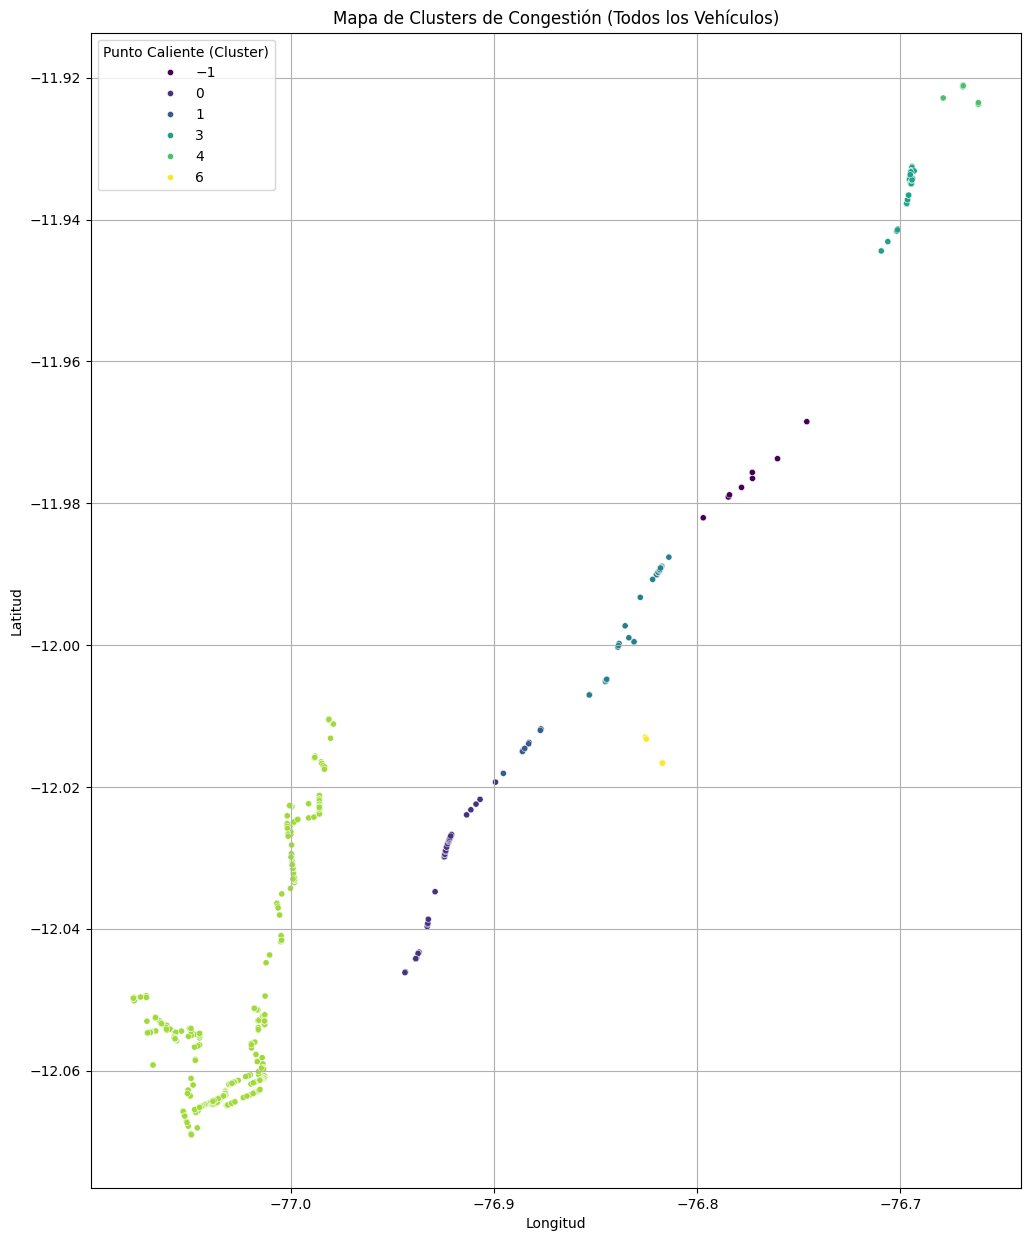

In [14]:
# Visualizar Resultados 
import matplotlib.pyplot as plt
import seaborn as sns

print("\n--- Generando Mapa de Clusters ---")

plt.figure(figsize=(12, 15))
sns.scatterplot(data=df_paradas_total, x='Longitud', y='Latitud', hue='cluster', palette='viridis', s=20)
plt.title('Mapa de Clusters de Congestión (Todos los Vehículos)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid(True)
plt.legend(title='Punto Caliente (Cluster)')

nombre_grafico = "mapa_congestion_final.png"
plt.savefig(nombre_grafico)

print(f"Gráfico guardado como '{nombre_grafico}'")
plt.show()

# Calculando el promedio de cada cluster encontrado por el DBSCAN

In [15]:
# promedio de sus coordenadas
centroides_clusters = df_paradas_total.groupby('cluster')[['Latitud', 'Longitud']].mean()

print("--- Coordenadas Promedio (Centroides) de cada Punto Caliente ---")
print(centroides_clusters)

--- Coordenadas Promedio (Centroides) de cada Punto Caliente ---
           Latitud   Longitud
cluster                      
-1      -11.976804 -76.775698
 0      -12.032020 -76.925766
 1      -12.014342 -76.884340
 2      -11.996707 -76.830843
 3      -11.935221 -76.695985
 4      -11.923292 -76.663327
 5      -12.050925 -77.026655
 6      -12.015213 -76.820490


In [19]:
!pip install geopy

# Verficamos la ubicación con la herramienta OPEN SOURCE GEOPY, la API de google maps necesita suscripción ;-;

In [20]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import time

# CONFIGURACIÓN

# Recreamos la tabla con las coordenadas promedio de tus clusters
data = {
    'Latitud': [-11.976804, -12.032020, -12.014342, -11.996707, -11.935221, -11.923292, -12.050925, -12.015213],
    'Longitud': [-76.775698, -76.925766, -76.884340, -76.830843, -76.695985, -76.663327, -77.026655, -76.820490]
}
index = [-1, 0, 1, 2, 3, 4, 5, 6]
centroides_clusters = pd.DataFrame(data, index=index)
centroides_clusters.index.name = 'cluster'


# PROCESO DE CONSULTA GRATUITO

# 1. Inicializar el geolocalizador de OpenStreetMap (Nominatim)
geolocator = Nominatim(user_agent="mi_app_hackathon_utec")

# 2. Crear una función de geocodificación inversa con límite de tiempo
#    Esto asegura que hacemos como máximo 1 llamada por segundo, para cumplir
#    con la política de uso del servicio gratuito.
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1)

direcciones = []
print("--- Consultando a la API gratuita de OpenStreetMap (esto puede tardar)... ---")

# 3. Iterar y buscar cada coordenada
for index, row in centroides_clusters.iterrows():
    lat = row['Latitud']
    lon = row['Longitud']
    
    # Creamos el string de la consulta
    query = f"{lat}, {lon}"
    
    # Hacemos la llamada a través de la función con límite de tiempo
    location = reverse(query)
    
    if location:
        direcciones.append(location.address)
        print(f"Cluster {index}: {location.address}")
    else:
        direcciones.append("No se encontró la dirección")
        print(f"Cluster {index}: No se encontró la dirección.")

# Añadimos la nueva columna con las direcciones al DataFrame
centroides_clusters['Direccion_Estimada'] = direcciones

print("\n--- Tabla Final con Direcciones ---")
print(centroides_clusters)

--- Consultando a la API gratuita de OpenStreetMap (esto puede tardar)... ---
Cluster -1: Avenida Malecón Manco Cápac, Asociación Huascarán, Chaclacayo, Lima, Lima Metropolitana, Lima, 15472, Perú
Cluster 0: Plaza Vea, Avenida Nicolás de Ayllón, Antiguo Mercado Ceres, Vitarte, Ate, Lima, Lima Metropolitana, Lima, 15498, Perú
Cluster 1: Carretera Central, Santa Clara, Ate, Lima, Lima Metropolitana, Lima, 15487, Perú
Cluster 2: Club Villa Tusán, Carretera Central, Pariachi, Chaclacayo, Ate, Lima, Lima Metropolitana, Lima, 15474, Perú
Cluster 3: Jirón Callao, San Antonio, Lurigancho, Lima, Lima Metropolitana, Lima, 15468, Perú
Cluster 4: Ricardo Palma, 103, Calle Córdova, Juan Velasco Alvarado, Ricardo Palma, Huarochirí, Lima, 15468, Perú
Cluster 5: Jirón Ayacucho, Urbanización Barrios Altos, Lima, Lima Metropolitana, Lima, 15001, Perú
Cluster 6: Zona D, Huaycán, Ate, Lima, Lima Metropolitana, Lima, 15483, Perú

--- Tabla Final con Direcciones ---
           Latitud   Longitud  \
cluster 

Guardar el Modelo

In [21]:
import joblib

# Suponiendo que tu modelo entrenado se llama 'dbscan'
# --- Para Guardar el Modelo ---
modelo1_dbscan = 'modelo_dbscan1.joblib'
joblib.dump(dbscan, modelo1_dbscan)

print(f"Modelo DBSCAN guardado como '{modelo1_dbscan}'")


# Cargar del Modelo
modelo_cargado1 = joblib.load(modelo1_dbscan)
print("Modelo DBSCAN cargado exitosamente desde el archivo.")

Modelo DBSCAN guardado como 'modelo_dbscan1.joblib'
Modelo DBSCAN cargado exitosamente desde el archivo.
